# **Correlator of Lorentz force felt by heavy quarks immersed in the Glasma**

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group
representation = 'fundamental'      # Fundamental or adjoint representation
boundary = 'periodic'        # Periodic boundary conditions or frozen dynamics at boundary

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.2     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 2    # Number of Glasma events
folder = 'corr_' + su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables and import all relevant modules

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group
os.environ["REPRESENTATION"] = representation
os.environ["BOUNDARY"] = boundary

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.fields_correlators import FieldsCorrelators
# Wong modules
from curraun import wong
wong.DEBUG = False
from curraun.wong import init_charge
from curraun.wong_correlators import ForceCorrelators
import curraun.kappa_wong as kappa_wong
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for computing correlators of Glasma electric and magnetic fields

In [3]:
import pickle
from tqdm import tqdm

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
def simulate(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxesest = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize Glasma fields correlators
    fieldscorr = FieldsCorrelators(s)

    tau, elcorr_T, elcorr_L = np.zeros(maxesest), np.zeros(maxesest), np.zeros(maxesest)
    # magcorr_T, magcorr_L = np.zeros(maxesest-formt), np.zeros(maxesest-formt)
    # [(GeV / fm) ** 2]
    units = (E0 ** 2 / hbarc) ** 2 

    with tqdm(total=maxesest+formt+1) as pbar:
        for t in range(maxesest+formt+1):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t==formt:  
                Eform = fieldscorr.compute_elfield()
                # Bform = fieldscorr.compute_magfield()
            elif t>=formt:
                EformE = fieldscorr.compute_elcorr(Eform)
                ExformEx, EyformEy, EzformEz = EformE[0], EformE[1], EformE[2]
                elcorr_T[t-formt-1], elcorr_L[t-formt-1] = (ExformEx + EyformEy) * units, EzformEz * units

                # BformB = fieldscorr.compute_magcorr(Bform)
                # BxformBx, ByformBy, BzformBz = BformB[0], BformB[1], BformB[2]
                # magcorr_T[t-formt-1], magcorr_L[t-formt-1] = (BxformBx + ByformBy) * units, BzformBz * units

                tau[t-formt-1] = t / DTS * a

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    corr_folder = p['FOLDER']
    if not os.path.isdir(corr_folder):
        os.makedirs(corr_folder)
    corr_path = current_path + '/' + results_folder + '/' + corr_folder + '/'
    os.chdir(corr_path)

    output['elcorr_T'], output['elcorr_L'], output['tau'] = elcorr_T, elcorr_L, tau
    # output['magcorr_T'], output['magcorr_L'] = magcorr_T, magcorr_L
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Run over multiple Glasma events

In [4]:
quarks = ['charm', 'beauty', 'massive']
quark_masses = [1.27, 4.18, 1000]

elcorr_T, elcorr_L, magcorr_T, magcorr_L, tau = {}, {}, {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize(), "quark")

    tag = quarks[iq]
    p['FOLDER'] = 'corr_' + su_group + '_' + quarks[iq]
    
    formt, maxesest = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
    taus = np.linspace(p['TFORM'], tau_sim+p['TFORM'], maxesest)

    elcorrs_T, elcorrs_L = [], []
    # magcorrs_T, magcorrs_L = [], []
    for ev in range(nevents):
        output = simulate(p, ev)
        elcorrs_T.append(output['elcorr_T'])
        elcorrs_L.append(output['elcorr_L'])
        # magcorrs_T.append(output['magcorr_T'])
        # magcorrs_L.append(output['magcorr_L'])

    elcorr_T[tag], elcorr_L[tag] = np.mean(elcorrs_T, axesesis=0), np.mean(elcorrs_L, axesesis=0)
    # magcorr_T[tag], magcorr_L[tag] = np.mean(magcorrs_T, axesesis=0), np.mean(magcorrs_L, axesesis=0)
    tau[tag] = taus

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['corr_T'], output['corr_L'], output['tau'] = elcorr_T, elcorr_L, tau
# output['magcorr_T'], output['magcorr_L'] = magcorr_T, magcorr_L
filename = 'electric_fields_correlators.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Charm quark


Event 2: 100%|██████████| 113/113 [00:33<00:00,  3.39it/s]


Beauty quark


Event 2: 100%|██████████| 91/91 [00:29<00:00,  3.06it/s]


Massive quark


Event 2: 100%|██████████| 82/82 [00:28<00:00,  2.90it/s]


## Plot the correlators of the Glasma electric fields

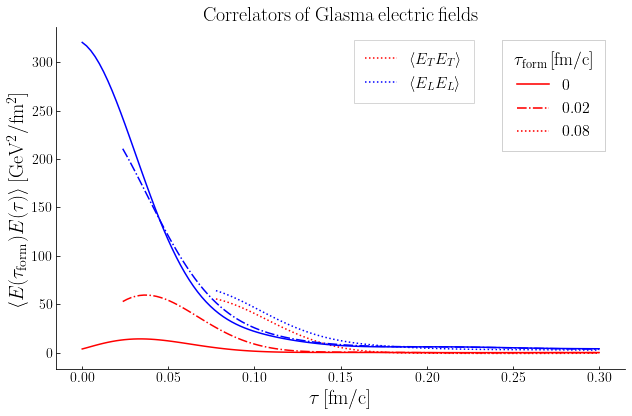

In [11]:
os.chdir(current_path)
data = pickle.load(open('results/electric_fields_correlators.pickle', 'rb'))
elcorr_T, elcorr_L, tau = data['corr_T'], data['corr_L'], data['tau']
quarks = data['quarks']

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
axeses = plt.subplot()
plt.title(r'$\mathrm{Correlators\,of\,Glasma\,electric\,fields}$', size = 20)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle E(\tau_\mathrm{form})E(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

axeses.spines["top"].set_visible(False)
axeses.spines["right"].set_visible(False)
axeses.tick_params(direction='in')

colors = ['red', 'blue']
linestyles = [':', '-.', '-']
iq = 0
for tag in quarks:
    axeses.plot(tau[tag], elcorr_T[tag], color=colors[0], linestyle=linestyles[iq])
    axeses.plot(tau[tag], elcorr_L[tag], color=colors[1], linestyle=linestyles[iq])
    iq += 1

labels_comp = [r'$\langle E_TE_T\rangle$', r'$\langle E_LE_L\rangle$']
labels_quarks = [r'$0$', r'$0.02$', r'$0.08$']
lines = axeses.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], labels_comp, loc = 'upper right', ncol=1, bbox_to_anchor=(0.74,0.97), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
axeses.add_artist(legend1)
legend2 = plt.legend([lines[i] for i in [4, 2, 0]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), title=r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
axeses.add_artist(legend2)

plt.tight_layout()
plt.savefig('glasma_elfields_corr.png', dpi=300, transparent=False, facecolor='white')

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the correlator of Lorentz force.

In [5]:
# Path where results are saved
# current_path = os.getcwd() 
# results_folder = 'results'
# if not os.path.isdir(results_folder):
#     os.makedirs(results_folder)
# os.chdir(current_path + '/' + results_folder)

# Simulation routine
def simulate(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxesest = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
    fcorr = ForceCorrelators(s, wong_solver, ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta
        angle = 2*np.pi*np.random.rand(1)
        p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    corr_T, corr_L = np.zeros(maxesest), np.zeros(maxesest)
    # [(GeV / fm) ** 2]
    units = (E0 ** 2 / hbarc) ** 2 / g ** 2

    with tqdm(total=maxesest+formt) as pbar:
        for t in range(maxesest+formt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                # Compute the correlator
                fcorr.compute_lorentz_force()
                if t==formt:
                    f0 = fcorr.f.copy()
                f = fcorr.f.copy()
                w = wong_solver.w.copy()
                fcorr.compute_force_correlator(f0, f, w, "naive")
                corr_comp = fcorr.corr.copy()
                corr_T[t-formt] = np.mean(corr_comp[:, 0] + corr_comp[:, 1], axesesis=0) * units
                corr_L[t-formt] = np.mean(corr_comp[:, 2], axesesis=0) * units

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = current_path + '/' + results_folder + '/' + wong_folder + '/'
    os.chdir(wong_path)

    output['corr_T'], output['corr_L'] = corr_T, corr_L
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Run over multiple Glasma events
Run the Wong solver over multiple Glasma events, for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [6]:
quarks = ['charm', 'beauty', 'massive']
quark_masses = [1.27, 4.18, 1000]
pTs = [0.5, 5.0, 10.0]

corr_T, corr_L, tau = {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize(), "quark")

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq]
        
        formt, maxesest = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        taus = np.linspace(p['TFORM'], tau_sim+p['TFORM'], maxesest)

        corrs_T, corrs_L = [], []
        for ev in range(nevents):
            output = simulate(p, ev)
            corrs_T.append(output['corr_T'])
            corrs_L.append(output['corr_L'])

        corr_T[tag], corr_L[tag] = np.mean(corrs_T, axesesis=0), np.mean(corrs_L, axesesis=0)
        tau[tag] = taus

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['corr_T'], output['corr_L'], output['tau'] = corr_T, corr_L, tau
filename = 'lorentz_forces_correlators.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Charm quark
Transverse momentum 0.5 GeV


Event 2: 100%|██████████| 112/112 [00:45<00:00,  2.45it/s]


Transverse momentum 5.0 GeV


Event 2: 100%|██████████| 112/112 [00:45<00:00,  2.45it/s]


Transverse momentum 10.0 GeV


Event 2: 100%|██████████| 112/112 [00:45<00:00,  2.45it/s]


Beauty quark
Transverse momentum 0.5 GeV


Event 2: 100%|██████████| 90/90 [00:42<00:00,  2.14it/s]


Transverse momentum 5.0 GeV


Event 2: 100%|██████████| 90/90 [00:42<00:00,  2.14it/s]


Transverse momentum 10.0 GeV


Event 2: 100%|██████████| 90/90 [00:42<00:00,  2.14it/s]


Massive quark
Transverse momentum 0.5 GeV


Event 2: 100%|██████████| 81/81 [00:40<00:00,  2.00it/s]


Transverse momentum 5.0 GeV


Event 2: 100%|██████████| 81/81 [00:40<00:00,  1.99it/s]


Transverse momentum 10.0 GeV


Event 2: 100%|██████████| 81/81 [00:40<00:00,  1.99it/s]


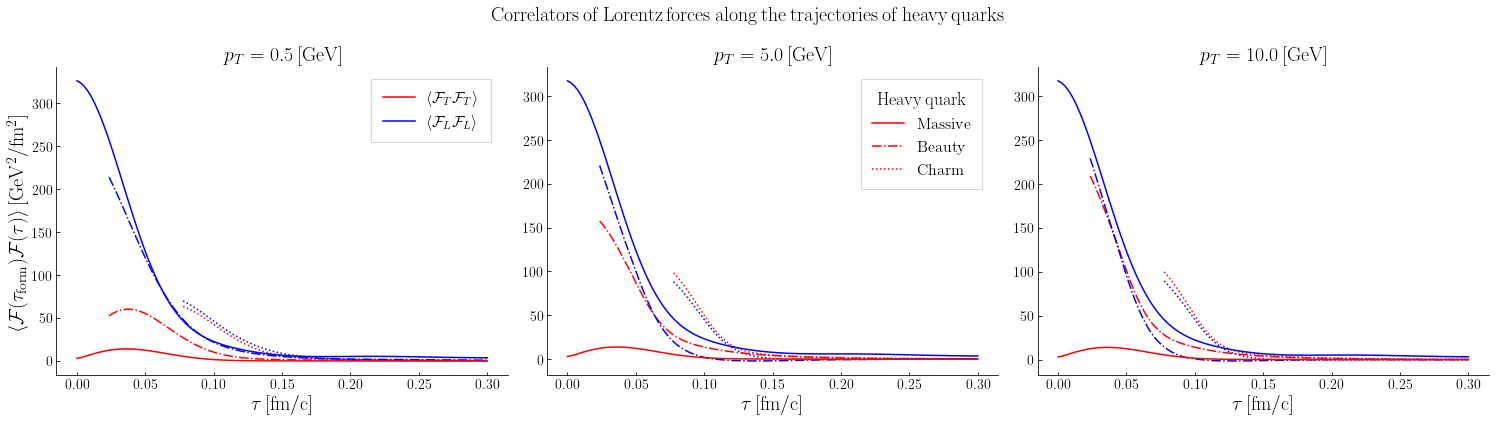

In [18]:
os.chdir(current_path)
data = pickle.load(open('results/lorentz_forces_correlators.pickle', 'rb'))
corr_T, corr_L, tau = data['corr_T'], data['corr_L'], data['tau']
quarks, pTs = data['quarks'], data['pTs']

plt.rcParams["figure.figsize"] = (21, 6)
fig, axeses = plt.subplots(1, 3)

colors = ['red', 'blue']
linestyles = [':', '-.', '-']
titles = [r'$p_T=0.5\,\mathrm{[GeV]}$', r'$p_T=5.0\,\mathrm{[GeV]}$', r'$p_T=10.0\,\mathrm{[GeV]}$']

for ipT in range(len(pTs)):
    pT = pTs[ipT]
    for iq in range(len(quarks)):
        quark = quarks[iq]
        tag = quark + "_pT_" + str(pT)
        axeses[ipT].plot(tau[tag], corr_T[tag], color=colors[0], linestyle=linestyles[iq])
        axeses[ipT].plot(tau[tag], corr_L[tag], color=colors[1], linestyle=linestyles[iq])

        axeses[ipT].spines["top"].set_visible(False)
        axeses[ipT].spines["right"].set_visible(False)
        axeses[ipT].tick_params(direction='in')

        axeses[ipT].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
        axeses[ipT].set_title(titles[ipT], size=20)

axeses[0].set_ylabel(r'$\langle \mathcal{F}(\tau_\mathrm{form})\mathcal{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

labels_comp = [r'$\langle \mathcal{F}_T\mathcal{F}_T\rangle$', r'$\langle \mathcal{F}_L\mathcal{F}_L\rangle$']
labels_quarks = [r'$\mathrm{Massive}$', r'$\mathrm{Beauty}$', r'$\mathrm{Charm}$']
lines = axeses[0].get_lines()
legend1 = axeses[0].legend([lines[i] for i in [4,5]], labels_comp, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend2 = axeses[1].legend([lines[i] for i in [4, 2, 0]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), title=r'$\mathrm{Heavy\,quark}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')

fig.suptitle(r'$\mathrm{Correlators\,of\,Lorentz\,forces\,along\,the\,trajectories\,of\,heavy\,quarks}$', size = 20)
plt.tight_layout()
plt.savefig('lorentz_force_corr.png', dpi=300, transparent=False, facecolor='white')

## Compute the decay times

In [19]:
import pickle
import scipy.optimize as opt

def exp_decay(tau, corr, tau_decay, const):
    return corr * np.exp(- tau / tau_decay) + const

correlators = pickle.load(open('results/lorentz_forces_correlators.pickle', 'rb'))
quarks, pTs = correlators['quarks'], correlators['pTs']

tau_decays = {}
init_guess = (200, 0.02, 0.)

for quark in quarks:
    for pT in pTs:
        tag = quark + '_pT_' + str(pT)
        tau, corr = correlators['tau'][tag], correlators['corr_T'][tag] + correlators['corr_L'][tag]
        popt, pcov = opt.curve_fit(exp_decay, tau, corr, maxesesfev=10000, p0=init_guess)
        corr, tau_decay, const = popt
        tau_decays[tag] = tau_decay
        print(quark.capitalize(), "quark pT", pT, "decay time", tau_decay, "[fm/c]")

Charm quark pT 0.5 decay time 0.03750216611814558 [fm/c]
Charm quark pT 5.0 decay time 0.02484153328789842 [fm/c]
Charm quark pT 10.0 decay time 0.024810475165377596 [fm/c]
Beauty quark pT 0.5 decay time 0.04069254487394941 [fm/c]
Beauty quark pT 5.0 decay time 0.029048101796251957 [fm/c]
Beauty quark pT 10.0 decay time 0.02666231061548261 [fm/c]
Massive quark pT 0.5 decay time 0.04638187329045649 [fm/c]
Massive quark pT 5.0 decay time 0.04646767654338153 [fm/c]
Massive quark pT 10.0 decay time 0.04641933770522892 [fm/c]


## Read data from files using Julia

In [1]:
using Pickle

results = ["electric_fields", "lorentz_forces"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "results/" * r * "_correlators.pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("corr_T_" * r,  data["corr_T"])
    string_as_varname("corr_L_" * r,  data["corr_L"])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_electric_fields["quarks"]
pTs = string.(data_lorentz_forces["pTs"])

3-element Vector{String}:
 "0.5"
 "5.0"
 "10.0"

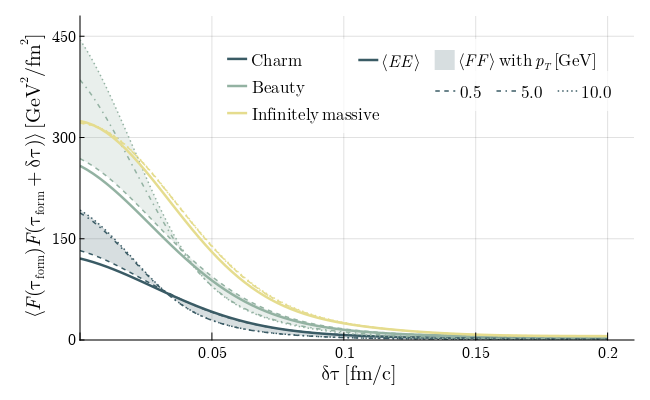

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000c961780, 3250.0, 2000.0)


In [6]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

sublegend = [LineElement(color = colors[1], strokecolor = :transparent, linestyle=linestyle) for linestyle in linestyles]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=L"\langle F(\tau_\mathrm{form})F(\tau_\mathrm{form}+\delta\tau)\rangle\,\mathrm{[GeV^2/fm^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) 
i = 1
for iq in 1:3
    for ipT in 1:length(pTs)
        tag_quark_pt = quarks[iq] * "_pT_" * pTs[ipT]
        string_as_varname("linepT"*string(i), lines!(ax, tau_lorentz_forces[tag_quark_pt].-tau_lorentz_forces[tag_quark_pt][1], corr_T_lorentz_forces[tag_quark_pt]+corr_L_lorentz_forces[tag_quark_pt], linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        i = i+1
    end
    tag_quark = quarks[iq]

    tag_quark_pt_first = quarks[iq] * "_pT_" * pTs[1] 
    tag_quark_pt_last = quarks[iq] * "_pT_" * pTs[3]
    string_as_varname("bandq"*string(iq), band!(ax, tau_lorentz_forces[tag_quark_pt_first].-tau_lorentz_forces[tag_quark_pt_first][1], corr_T_lorentz_forces[tag_quark_pt_first]+corr_L_lorentz_forces[tag_quark_pt_first], corr_T_lorentz_forces[tag_quark_pt_last]+corr_L_lorentz_forces[tag_quark_pt_last]; color = (colors[iq], 0.2)))

    string_as_varname("lineq"*string(iq), lines!(ax, tau_electric_fields[tag_quark].-tau_electric_fields[tag_quark][1], corr_T_electric_fields[tag_quark]+corr_L_electric_fields[tag_quark], linewidth = 2.5, color=colors[iq]))
end

ylims!(ax, 0, 480)
xlims!(ax, 0, 0.21)
ax.yticks = (150*(0:3), ["0", "150", "300", "450"])
ax.xticks = (0.05*(0:4), ["", "0.05", "0.1", "0.15", "0.2"])

axislegend(ax, [lineq1, lineq2, lineq3], [L"\mathrm{Charm}", L"\mathrm{Beauty}", L"\mathrm{Infinitely\,massive}"],  labelsize=17, 
    position = (0.35, 0.94), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(ax, [lineq1, bandq1], 
    [L"\langle EE\,\rangle", L"\langle FF\,\rangle\,\mathrm{with}\,p_T\,\mathrm{[GeV]}"], 
    labelsize=17, position = (0.93,0.95), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [linepT1, linepT2, linepT3], 
    [L"0.5", L"5.0", L"10.0"],
    labelsize=17, position = (0.99,0.83), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor = (:white, 0))
display(fig)

save("corr_EEvsFF_charm+beauty_pTs.png", fig, px_per_unit = 5.0) 

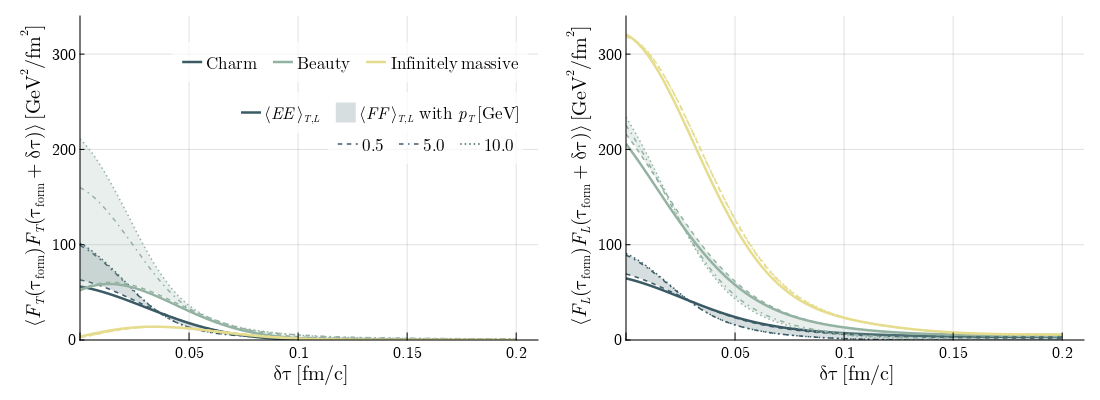

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000c8b1240, 5500.0, 2000.0)


In [7]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

sublegend = [LineElement(color = colors[1], strokecolor = :transparent, linestyle=linestyle) for linestyle in linestyles]

ylabels = [L"\langle F_T(\tau_\mathrm{form})F_T(\tau_\mathrm{form}+\delta\tau)\rangle\,\mathrm{[GeV^2/fm^2]}", L"\langle F_L(\tau_\mathrm{form})F_L(\tau_\mathrm{form}+\delta\tau)\rangle\,\mathrm{[GeV^2/fm^2]}"]
fig = Figure(resolution = (1100, 400), font = "CMU Serif")
axes = [Axis(fig[1,i], xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) for i in 1:2]
i = 1
for iq in 1:3
    for ipT in 1:length(pTs)
        tag_quark_pt = quarks[iq] * "_pT_" * pTs[ipT]
        string_as_varname("linepT_T_"*string(i), lines!(axes[1], tau_lorentz_forces[tag_quark_pt].-tau_lorentz_forces[tag_quark_pt][1], corr_T_lorentz_forces[tag_quark_pt], linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        string_as_varname("linepT_L_"*string(i), lines!(axes[2], tau_lorentz_forces[tag_quark_pt].-tau_lorentz_forces[tag_quark_pt][1], corr_L_lorentz_forces[tag_quark_pt], linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        i = i+1
    end
    tag_quark = quarks[iq]

    tag_quark_pt_first = quarks[iq] * "_pT_" * pTs[1] 
    tag_quark_pt_last = quarks[iq] * "_pT_" * pTs[3]
    string_as_varname("bandq_T_"*string(iq), band!(axes[1], tau_lorentz_forces[tag_quark_pt_first].-tau_lorentz_forces[tag_quark_pt_first][1], corr_T_lorentz_forces[tag_quark_pt_first], corr_T_lorentz_forces[tag_quark_pt_last]; color = (colors[iq], 0.2)))
    string_as_varname("bandq_L_"*string(iq), band!(axes[2], tau_lorentz_forces[tag_quark_pt_first].-tau_lorentz_forces[tag_quark_pt_first][1], corr_L_lorentz_forces[tag_quark_pt_first], corr_L_lorentz_forces[tag_quark_pt_last]; color = (colors[iq], 0.2)))

    string_as_varname("lineq_T_"*string(iq), lines!(axes[1], tau_electric_fields[tag_quark].-tau_electric_fields[tag_quark][1], corr_T_electric_fields[tag_quark], linewidth = 2.5, color=colors[iq]))
    string_as_varname("lineq_L_"*string(iq), lines!(axes[2], tau_electric_fields[tag_quark].-tau_electric_fields[tag_quark][1], corr_L_electric_fields[tag_quark], linewidth = 2.5, color=colors[iq]))
end

for i in 1:2
    ylims!(axes[i], 0, 340)
    xlims!(axes[i], 0, 0.21)
    axes[i].yticks = (100*(0:3), ["0", "100", "200", "300"])
    axes[i].xticks = (0.05*(0:4), ["", "0.05", "0.1", "0.15", "0.2"])
end

axislegend(axes[1], [lineq_T_1, lineq_T_2, lineq_T_3], [L"\mathrm{Charm}", L"\mathrm{Beauty}", L"\mathrm{Infinitely\,massive}"],  labelsize=17, 
    position = (1, 0.94), bgcolor = (:white, 0.7), framecolor = (:white, 0), orientation = :horizontal)
axislegend(axes[1], [lineq_L_1, bandq_L_1], 
    [L"\langle EE\,\rangle_{T,L}", L"\langle FF\,\rangle_{T,L}\,\,\mathrm{with}\,\,p_T\,\mathrm{[GeV]}"], 
    labelsize=17, position = (1,0.75), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(axes[1], [linepT_L_1, linepT_L_2, linepT_L_3], 
    [L"0.5", L"5.0", L"10.0"],
    labelsize=17, position = (0.98,0.63), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("corr_EEvsFF_T+L_charm+beauty_pTs.png", fig, px_per_unit = 5.0) 